### Our business problem?

The dataset contains BBC news text and its category in a two-column CSV format. Suppose we never had a category of the news article with us and we had to cluster together similar documents by similar topics they belong to. LDA came to the rescue to solve this for us.

In [1]:
# load required libraries

import re
import nltk
import spacy
import gensim
import pyLDAvis
import nlp
nltk.download('stopwords')
import pandas as pd
import numpy as np
from pprint import pprint
import tqdm

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for Lemmatization
import spacy

# plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\16476\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv(r'E:\Vocational\Lighthouse Labs\Flex Course\C08_Machine Learning Application\natural_language_processing\data\bbc_text.csv')
df.shape

(2225, 2)

### Preprocessing Data

In [3]:
# display the column names to find the correct one
print(df.columns)

Index(['category', 'text'], dtype='object')


In [4]:
# convert to list
data = df.text.values.tolist()

# remove Emails
data = [re.sub(r'\S*@\S*\s?', '', i) for i in data]

# remove new line characters
data = [re.sub(r'\s+', ' ', i) for i in data]

# remove distracting single quotes
data = [re.sub(r"\'", "", i) for i in data]

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:1])

[['tv',
  'future',
  'in',
  'the',
  'hands',
  'of',
  'viewers',
  'with',
  'home',
  'theatre',
  'systems',
  'plasma',
  'high',
  'definition',
  'tvs',
  'and',
  'digital',
  'video',
  'recorders',
  'moving',
  'into',
  'the',
  'living',
  'room',
  'the',
  'way',
  'people',
  'watch',
  'tv',
  'will',
  'be',
  'radically',
  'different',
  'in',
  'five',
  'years',
  'time',
  'that',
  'is',
  'according',
  'to',
  'an',
  'expert',
  'panel',
  'which',
  'gathered',
  'at',
  'the',
  'annual',
  'consumer',
  'electronics',
  'show',
  'in',
  'las',
  'vegas',
  'to',
  'discuss',
  'how',
  'these',
  'new',
  'technologies',
  'will',
  'impact',
  'one',
  'of',
  'our',
  'favourite',
  'pastimes',
  'with',
  'the',
  'us',
  'leading',
  'the',
  'trend',
  'programmes',
  'and',
  'other',
  'content',
  'will',
  'be',
  'delivered',
  'to',
  'viewers',
  'via',
  'home',
  'networks',
  'through',
  'cable',
  'satellite',
  'telecoms',
  'companies

The code provided performs text preprocessing by:

1. Defining a function `sent_to_words` that tokenizes each sentence into words and removes punctuations.
2. Applying this function to a list of sentences (`data`), resulting in a list of tokenized sentences (`data_words`).
3. Printing the first tokenized sentence to verify the output.

In summary, it converts sentences into lists of words, removing any punctuation.

In [6]:
# NLTK stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [9]:
import spacy

# load the spacy model directly by name
nlp = spacy.load('en_core_web_sm')

def lemmatization(texts, allowed_postags=['NOUN']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [10]:
# remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# do lemmatization keeping only noun
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN'])

In [11]:
# show results
print(data_lemmatized[:2])

[['hand', 'viewer', 'home', 'theatre', 'system', 'definition', 'video', 'recorder', 'living', 'room', 'way', 'people', 'tv', 'year', 'time', 'panel', 'consumer', 'electronic', 'show', 'technology', 'pastime', 'trend', 'programme', 'content', 'viewer', 'home', 'network', 'cable', 'satellite', 'telecom', 'company', 'service', 'provider', 'room', 'device', 'technology', 'video', 'recorder', 'dvr', 'box', 'sky', 'system', 'people', 'record', 'store', 'play', 'pause', 'tv', 'programme', 'technology', 'tv', 'definition', 'tv', 'business', 'lack', 'definition', 'programming', 'people', 'wind', 'advert', 'network', 'channel', 'schedule', 'network', 'cable', 'satellite', 'company', 'term', 'advertising', 'revenue', 'brand', 'identity', 'viewer', 'loyalty', 'channel', 'technology', 'moment', 'concern', 'service', 'sky', 'today', 'month', 'year', 'time', 'website', 'issue', 'advertising', 'revenue', 'issue', 'moment', 'brand', 'loyalty', 'content', 'brand', 'network', 'brand', 'brand', 'communica

### LDA Model

In [13]:
#the two main inputs to the LDA topic model are the dictionary (id2word) and the corpus. Let's create them.

# create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
print(id2word)

# create Corpus
texts = data_lemmatized

# term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

Dictionary<10721 unique tokens: ['advert', 'advertising', 'bill', 'book', 'box']...>


### Creating a Base Model

In [14]:
# baseline model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=5, random_state=100, chunksize=200, passes=10, per_word_topics=True)

In [15]:
# print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"game" + 0.026*"player" + 0.018*"team" + 0.017*"domain" + '
  '0.017*"club" + 0.016*"time" + 0.015*"side" + 0.012*"goal" + 0.012*"manager" '
  '+ 0.011*"wale"'),
 (1,
  '0.022*"people" + 0.013*"phone" + 0.012*"technology" + 0.011*"attack" + '
  '0.011*"computer" + 0.011*"service" + 0.011*"network" + 0.010*"site" + '
  '0.009*"user" + 0.009*"software"'),
 (2,
  '0.026*"year" + 0.018*"sale" + 0.014*"company" + 0.011*"market" + '
  '0.010*"price" + 0.009*"budget" + 0.009*"growth" + 0.009*"car" + '
  '0.009*"government" + 0.008*"spending"'),
 (3,
  '0.019*"film" + 0.016*"people" + 0.013*"government" + 0.012*"party" + '
  '0.011*"election" + 0.008*"year" + 0.008*"law" + 0.008*"labour" + '
  '0.007*"age" + 0.007*"plan"'),
 (4,
  '0.031*"year" + 0.016*"music" + 0.014*"world" + 0.013*"time" + '
  '0.011*"number" + 0.010*"record" + 0.009*"award" + 0.009*"week" + '
  '0.008*"album" + 0.008*"dance"')]


### Topic Coherence - How good a given topic is?

In [16]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4860434652244184


### Model Improvement

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, random_state=100,
                                                chunksize=200, passes=10, per_word_topics=True, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=8, step=1)

In [ ]:
# show graph
limit=8; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, random_state=100, chunksize=200, passes=10, alpha=a, eta=b)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [ ]:
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 7
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

In [ ]:
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [], 'Topics': [], 'Alpha': [], 'Beta': [], 'Coherence': []}

if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_new.csv', index=False)
    pbar.close()

### Final LDA Model

In [18]:
# passes: number of passes through the entire corpus
# chunksize: number of documents to load into memory at a time and process E step of EM
lda_model_final = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=5, random_state=100, chunksize=200, passes=10, alpha=0.01, eta='symmetric', per_word_topics=True)

In [19]:
coherence_model_lda = CoherenceModel(model=lda_model_final, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5075842122856733


### Visualize the Topics (Keywords)

In [22]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model_final, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.084842 -0.057940       1        1  23.379646
2     -0.174752 -0.010806       2        1  23.341674
1     -0.097092  0.131070       3        1  22.659750
0      0.134621 -0.225999       4        1  15.864158
3      0.222064  0.163674       5        1  14.754772, topic_info=       Term         Freq        Total Category  logprob  loglift
240    film  1165.000000  1165.000000  Default  30.0000  30.0000
163    game  1203.000000  1203.000000  Default  29.0000  29.0000
544  player   764.000000   764.000000  Default  28.0000  28.0000
312   party   594.000000   594.000000  Default  27.0000  27.0000
142   phone   552.000000   552.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
3      book   127.344039   231.583258   Topic5  -5.3854   1.3156
171     man   140.499524   386.822701   Topic5  -5.2871   0.9008
97     time   182.260710  1504.123620   Topic5  -5.0269  -0.1969
559   world   155.219253   876.529829   Topic5  -5.1875   0.1825
191    week   140.812034   830.327666   Topic5  -5.2849   0.1392

[328 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
589       5  0.997005           actor
873       5  0.996798         actress
764       2  0.991083  administration
1407      5  0.991607          advice
502       1  0.735075             age
...     ...       ...             ...
111       1  0.098951            year
111       2  0.390267            year
111       3  0.094107            year
111       4  0.196517            year
111       5  0.220390            year

[537 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 1, 4])

### Topic Distribution Across Documents

In [25]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df, pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])], ignore_index=True)
            else:
                break
    
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

In [26]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_final, corpus=corpus, texts=data)

In [27]:
df_topic_distribution = df_topic_sents_keywords['Dominant_Topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Dominant_Topic', 'Num Documents']
df_topic_distribution.sort_values('Dominant_Topic')

,Dominant_Topic,Num Documents
1,0,491
3,1,376
0,2,529
4,3,376
2,4,453


### Visualize Topics - Wordcloud of Top N words in each topic

In [31]:
# Wordcloud of Top N words in each topic
import wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=2800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_final.show_topics(formatted=False)
len(topics)

5

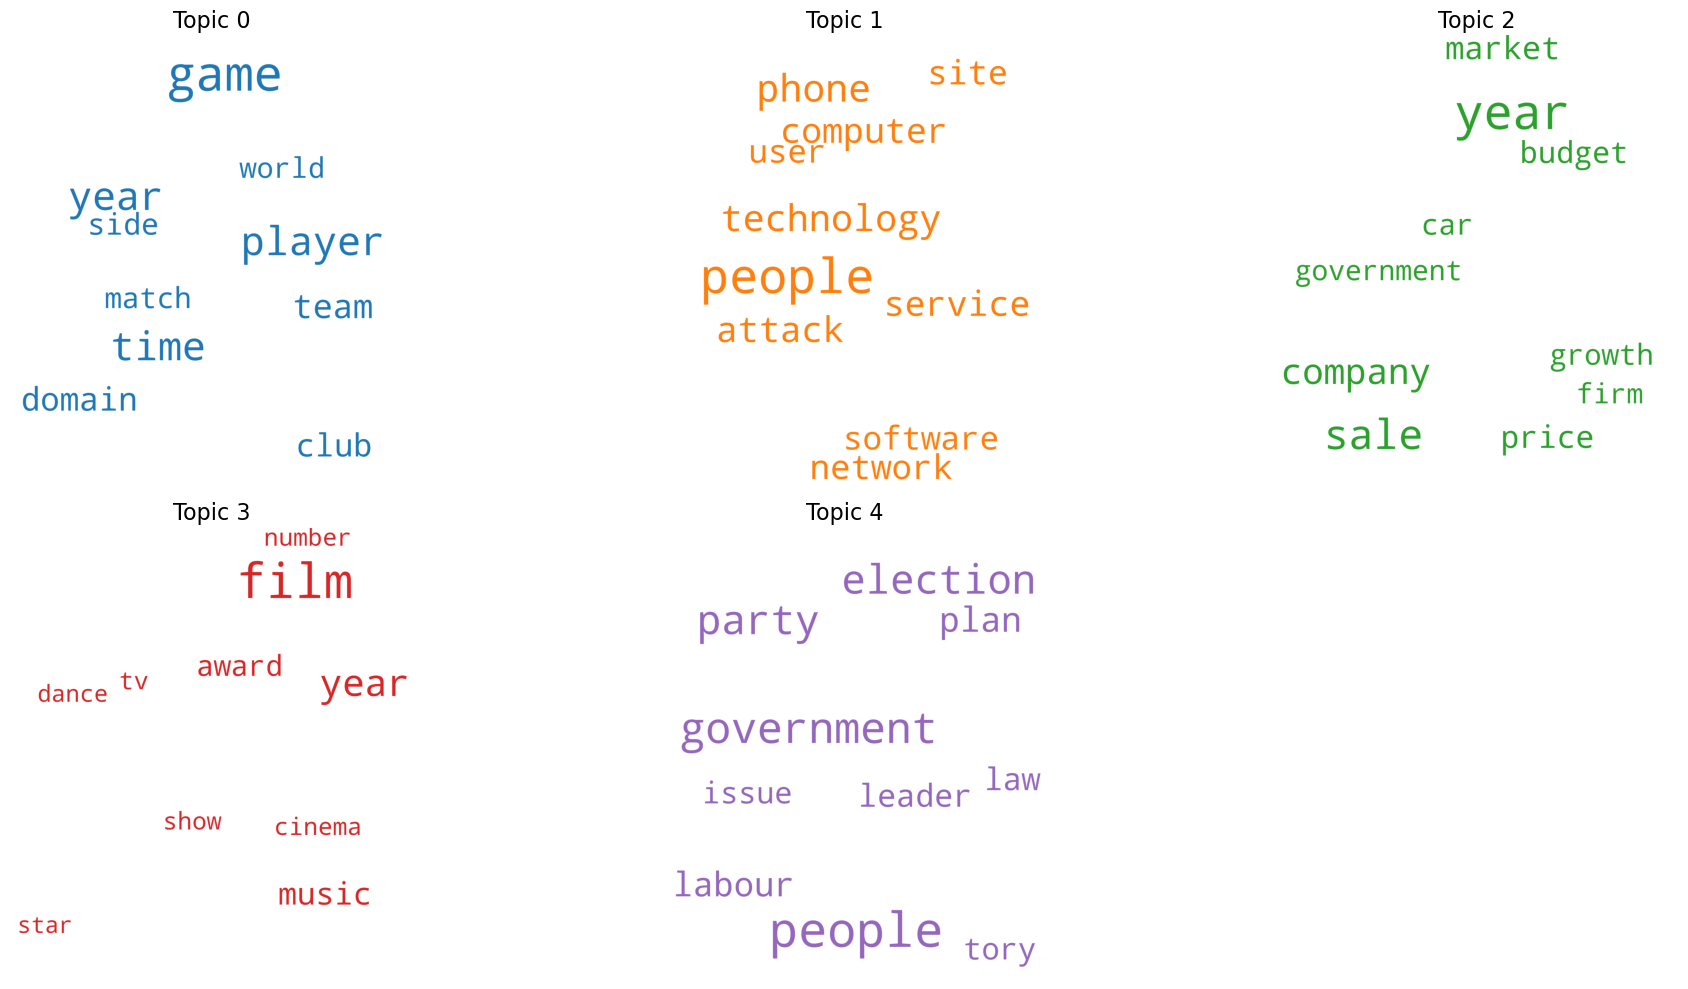

In [32]:
# Number of topics
num_topics = len(topics)

# Determine the grid size for subplots
ncols = 3
nrows = (num_topics // ncols) + (num_topics % ncols > 0)

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i < num_topics:
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        ax.imshow(cloud)
        ax.set_title('Topic ' + str(i), fontdict=dict(size=16))
        ax.axis('off')
    else:
        fig.delaxes(ax)  # Remove empty subplots

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()